In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
#import xgboost as xgb
#import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
import json
import ast
import eli5
from functools import reduce
import warnings
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt
from lightgbm import plot_tree
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample
import time
import gc
warnings.filterwarnings('ignore')
#import shap

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
'''
train = pd.read_csv('dataset-0510/train.csv')
test  = pd.read_csv('dataset-0510/test.csv')
train.drop(['village'], axis =1, inplace = True)
test.drop(['village'], axis =1, inplace = True)
'''

"\ntrain = pd.read_csv('dataset-0510/train.csv')\ntest  = pd.read_csv('dataset-0510/test.csv')\ntrain.drop(['village'], axis =1, inplace = True)\ntest.drop(['village'], axis =1, inplace = True)\n"

In [17]:
train = pd.read_csv('FE_train.csv')
test  = pd.read_csv('FE_test.csv')
gc.collect()

2409

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 263 entries, III_10 to department
dtypes: float64(86), int64(176), object(1)
memory usage: 120.4+ MB


In [16]:
#categorical feature to one-hot
def one_hot(train, test, categorical_features):
    data = pd.concat([train, test], axis=0)
    for i in categorical_features:
        data = data.join(pd.get_dummies(data[i], prefix = i))
        data.drop(i, axis = 1, inplace =True)
    train = data[:60000]
    test  = data[60000:]
    return train, test

In [7]:
def display_importances(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [8]:
def Submission(Ids, preds):
    file_name = datetime.datetime.today().strftime('%m-%d-%H-%M')
    submission = pd.DataFrame({'building_id' : Ids, 'total_price' : preds})
    if not os.path.isdir('Submission'):
        os.makedirs('Submission')
    submission.to_csv('Submission/' + file_name + '.csv', index= False)

In [9]:
def lgb_model(split_num, train, test,features, stratified = False, if_one_hot = True):
    
    category_cols = ['building_material', 'building_type','building_use','city','inter_btw_parking_building']
    if stratified:
        kf = StratifiedKFold(n_splits = split_num, random_state = 42, shuffle = True)
    else :
        kf = KFold(n_splits = split_num, random_state=42, shuffle=True)
    train['total_price_log'] = np.log1p(train['total_price'])
    feature_importance_df = pd.DataFrame()
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    
    param ={
        'n_estimators': 10000, 'max_depth' : 5, 'num_leaves' :30,         
        'objective': 'regression',   'metric':'rmse',   
        'learning_rate': 0.01,      'boosting': 'gbdt',     'min_data_in_leaf': 10,
        'feature_fraction': 0.9,    'bagging_freq':1,       'bagging_fraction': 0.9,     'importance_type': 'gain',
        'lambda_l1': 0.2,  'subsample': .8,   'colsample_bytree': .9
    }
    if if_one_hot :
        train, test = one_hot(train, test, category_cols)
        features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 
        print(len(features))
        for fold_, (trn_idx, val_idx) in enumerate(kf.split(train[features].values,train['total_price_log'].values)):
            trn_data = lgb.Dataset(train.iloc[trn_idx][features], label= train['total_price_log'].iloc[trn_idx])
            val_data = lgb.Dataset(train.iloc[val_idx][features], label= train['total_price_log'].iloc[val_idx])
            
            
            clf = lgb.train(params= param, train_set= trn_data, valid_sets= [trn_data, val_data], verbose_eval=5000, early_stopping_rounds= 3000)
            oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)
            predictions += clf.predict(test[features], num_iteration = clf.best_iteration) / kf.n_splits
            
            y   = np.expm1(train['total_price_log'].iloc[val_idx]) 
            yhat = np.expm1(oof[val_idx])
            Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
            print('fold {} hit_score : {}'.format(fold_ + 1, round(Hit_score, 4) /len(train.iloc[val_idx]) * 10000))
            
            fold_importance_df = pd.DataFrame()
            fold_importance_df['feature']    = features
            fold_importance_df['importance'] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
            fold_importance_df['fold']       = fold_ + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    if not if_one_hot :
        print(len(features))        
        for fold_, (trn_idx, val_idx) in enumerate(kf.split(train[features].values,train['total_price_log'].values)):
            trn_data = lgb.Dataset(train.iloc[trn_idx][features], label= train['total_price_log'].iloc[trn_idx])
            val_data = lgb.Dataset(train.iloc[val_idx][features], label= train['total_price_log'].iloc[val_idx])
            
            
            clf = lgb.train(params= param, train_set= trn_data, valid_sets= [trn_data, val_data], verbose_eval=10000, early_stopping_rounds= 50000, categorical_feature=category_cols)
            oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)
            predictions += clf.predict(test[features], num_iteration = clf.best_iteration) / kf.n_splits
            
            y   = np.expm1(train['total_price_log'].iloc[val_idx]) 
            yhat = np.expm1(oof[val_idx])
            Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
            print('fold {} hit_score : {}'.format(fold_ + 1, round(Hit_score, 4) /len(train.iloc[val_idx]) * 10000))
            print('-'*30)
            fold_importance_df = pd.DataFrame()
            fold_importance_df['feature']    = features
            fold_importance_df['importance'] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
            fold_importance_df['fold']       = fold_ + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('CV scrore : {}'.format(sqrt(mean_squared_error(train['total_price_log'], oof))))
    print('-'*30)
    y = np.expm1(train['total_price_log']) 
    yhat = np.expm1(oof)
    Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
    print('Hit ratye : {}'.format(round(Hit_score, 4) /len(train) * 10000))
    
    display_importances(feature_importance_df)
    return predictions


In [10]:
#1
begin = time.time()
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 
prediction = lgb_model(5, train, test, features, stratified = False, if_one_hot = True)
prediction = np.expm1(prediction)
print((time.time() - begin) / 60)
print('總共花：{} 分'.format((time.time() - begin) / 60))
Submission(test['building_id'], prediction)

305
Training until validation scores don't improve for 3000 rounds.
[5000]	training's rmse: 0.165335	valid_1's rmse: 0.208808
[10000]	training's rmse: 0.129957	valid_1's rmse: 0.198328
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.129957	valid_1's rmse: 0.198328


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields building_material_5

In [ ]:
#1
begin = time.time()
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 
prediction = lgb_model(5, train, test, features, stratified = False, if_one_hot = False)
prediction = np.expm1(prediction)
print((time.time() - begin) / 60)
print('總共花：{} 分'.format((time.time() - begin) / 60))
Submission(test['building_id'], prediction)

Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.233587	valid_1's rmse: 0.247362
[2000]	training's rmse: 0.205601	valid_1's rmse: 0.228334
[3000]	training's rmse: 0.189219	valid_1's rmse: 0.219333
[4000]	training's rmse: 0.1772	valid_1's rmse: 0.213785
[5000]	training's rmse: 0.167513	valid_1's rmse: 0.209892
[6000]	training's rmse: 0.159056	valid_1's rmse: 0.20685
[7000]	training's rmse: 0.151621	valid_1's rmse: 0.204568
[8000]	training's rmse: 0.14493	valid_1's rmse: 0.202733
[9000]	training's rmse: 0.138906	valid_1's rmse: 0.201193
[10000]	training's rmse: 0.133377	valid_1's rmse: 0.199931
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.133377	valid_1's rmse: 0.199931
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.231893	valid_1's rmse: 0.259265
[2000]	training's rmse: 0.204193	valid_1's rmse: 0.239284
[3000]	training's rmse: 0.188446	valid_1's rmse: 0.229954
[4000]	trainin

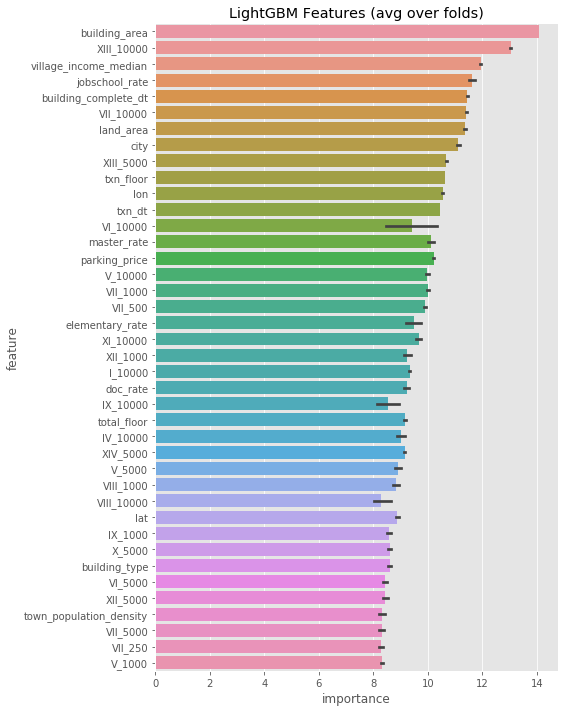

In [8]:
#1
begin = time.time()
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 
prediction = lgb_model(5, train, test, features, stratified = False)
prediction = np.expm1(prediction)
print((time.time() - begin) / 60)

In [18]:
#2
begin = time.time()
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 
prediction = lgb_model(5, train, test, features, stratified = False)
prediction = np.expm1(prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))

308
Training until validation scores don't improve for 3000 rounds.


KeyboardInterrupt: 

Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.232985	valid_1's rmse: 0.246421
[2000]	training's rmse: 0.204996	valid_1's rmse: 0.227201
[3000]	training's rmse: 0.188264	valid_1's rmse: 0.218214
[4000]	training's rmse: 0.175945	valid_1's rmse: 0.212552
[5000]	training's rmse: 0.165748	valid_1's rmse: 0.208545
[6000]	training's rmse: 0.15685	valid_1's rmse: 0.205436
[7000]	training's rmse: 0.149162	valid_1's rmse: 0.203026
[8000]	training's rmse: 0.142223	valid_1's rmse: 0.201148
[9000]	training's rmse: 0.136073	valid_1's rmse: 0.199539
[10000]	training's rmse: 0.130431	valid_1's rmse: 0.198318
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.130431	valid_1's rmse: 0.198318
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.230677	valid_1's rmse: 0.258975
[2000]	training's rmse: 0.202762	valid_1's rmse: 0.239125
[3000]	training's rmse: 0.18618	valid_1's rmse: 0.229362
[4000]	train

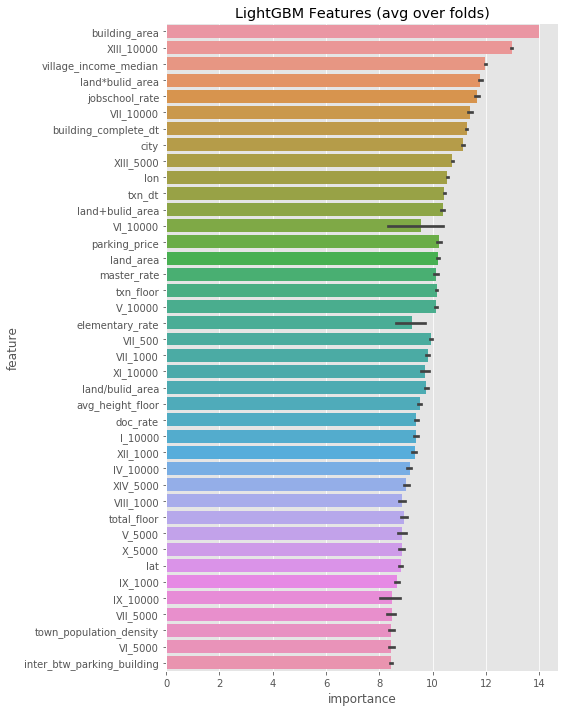

In [18]:
#3
begin = time.time()
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 
prediction = lgb_model(5, train, test, features, stratified = False)
prediction = np.expm1(prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))

Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.232766	valid_1's rmse: 0.246273
[2000]	training's rmse: 0.206557	valid_1's rmse: 0.228016
[3000]	training's rmse: 0.191353	valid_1's rmse: 0.219472
[4000]	training's rmse: 0.179764	valid_1's rmse: 0.213801
[5000]	training's rmse: 0.170077	valid_1's rmse: 0.209717
[6000]	training's rmse: 0.161416	valid_1's rmse: 0.20652
[7000]	training's rmse: 0.153809	valid_1's rmse: 0.204056
[8000]	training's rmse: 0.146921	valid_1's rmse: 0.202054
[9000]	training's rmse: 0.140648	valid_1's rmse: 0.200377
[10000]	training's rmse: 0.134905	valid_1's rmse: 0.198907
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.134905	valid_1's rmse: 0.198907
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.231387	valid_1's rmse: 0.25945
[2000]	training's rmse: 0.205053	valid_1's rmse: 0.240459
[3000]	training's rmse: 0.190029	valid_1's rmse: 0.231424
[4000]	train

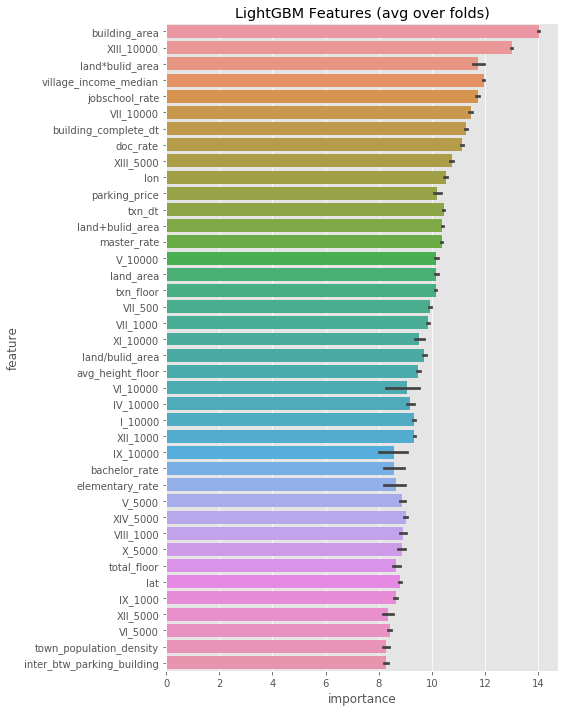

In [27]:
#4
begin = time.time()
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log','location_2']] 
prediction = lgb_model(5, train, test, features, stratified = False)
prediction = np.expm1(prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))

Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.232609	valid_1's rmse: 0.246347
[2000]	training's rmse: 0.204792	valid_1's rmse: 0.227209
[3000]	training's rmse: 0.187952	valid_1's rmse: 0.217996
[4000]	training's rmse: 0.175692	valid_1's rmse: 0.212365
[5000]	training's rmse: 0.165801	valid_1's rmse: 0.208439
[6000]	training's rmse: 0.15698	valid_1's rmse: 0.205359
[7000]	training's rmse: 0.149239	valid_1's rmse: 0.202935
[8000]	training's rmse: 0.142337	valid_1's rmse: 0.200942
[9000]	training's rmse: 0.136213	valid_1's rmse: 0.199444
[10000]	training's rmse: 0.130531	valid_1's rmse: 0.198152
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.130531	valid_1's rmse: 0.198152
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.230658	valid_1's rmse: 0.259221
[2000]	training's rmse: 0.20298	valid_1's rmse: 0.239184
[3000]	training's rmse: 0.186199	valid_1's rmse: 0.229247
[4000]	train

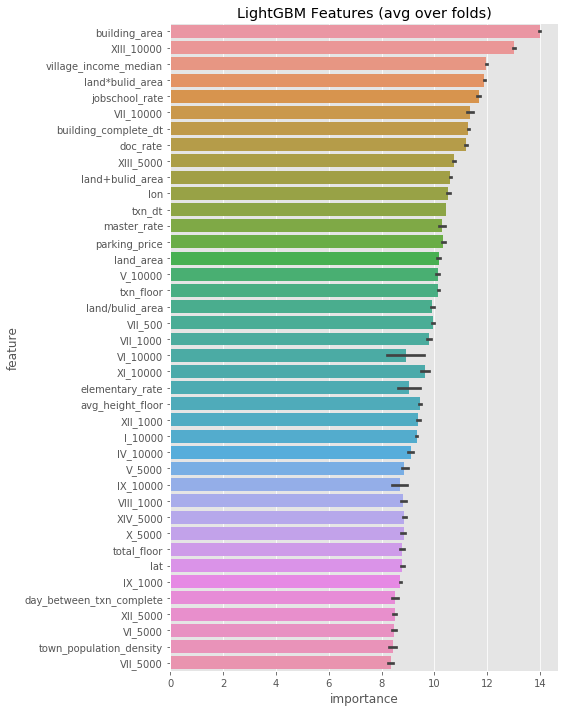

In [37]:
#5
begin = time.time()
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 
prediction = lgb_model(5, train, test, features, stratified = False)
prediction = np.expm1(prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))

In [ ]:
#6
begin = time.time()
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 

prediction = lgb_model(5, train, test, features, stratified = False)
prediction = np.expm1(prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))

Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.229704	valid_1's rmse: 0.243614
[2000]	training's rmse: 0.202732	valid_1's rmse: 0.22552
[3000]	training's rmse: 0.186309	valid_1's rmse: 0.216743
[4000]	training's rmse: 0.174273	valid_1's rmse: 0.211381
[5000]	training's rmse: 0.164455	valid_1's rmse: 0.20754
[6000]	training's rmse: 0.155887	valid_1's rmse: 0.20464
[7000]	training's rmse: 0.148379	valid_1's rmse: 0.202289
[8000]	training's rmse: 0.141618	valid_1's rmse: 0.200402
[9000]	training's rmse: 0.135588	valid_1's rmse: 0.198871
[10000]	training's rmse: 0.129973	valid_1's rmse: 0.197672
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.129973	valid_1's rmse: 0.197672
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.227702	valid_1's rmse: 0.255516
[2000]	training's rmse: 0.200714	valid_1's rmse: 0.236906
[3000]	training's rmse: 0.184651	valid_1's rmse: 0.227689
[4000]	traini

Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.223423	valid_1's rmse: 0.240142
[2000]	training's rmse: 0.195757	valid_1's rmse: 0.223109
[3000]	training's rmse: 0.18012	valid_1's rmse: 0.215326
[4000]	training's rmse: 0.168437	valid_1's rmse: 0.210592
[5000]	training's rmse: 0.158782	valid_1's rmse: 0.207258
[6000]	training's rmse: 0.150676	valid_1's rmse: 0.204936
[7000]	training's rmse: 0.143538	valid_1's rmse: 0.203073
[8000]	training's rmse: 0.137152	valid_1's rmse: 0.201594
[9000]	training's rmse: 0.131554	valid_1's rmse: 0.200352
[10000]	training's rmse: 0.1265	valid_1's rmse: 0.199382
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.1265	valid_1's rmse: 0.199382
fold 1 hit_score : 5083.333333333333
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.221616	valid_1's rmse: 0.253715
[2000]	training's rmse: 0.194669	valid_1's rmse: 0.235446
[3000]	training's rmse: 0.179356	val

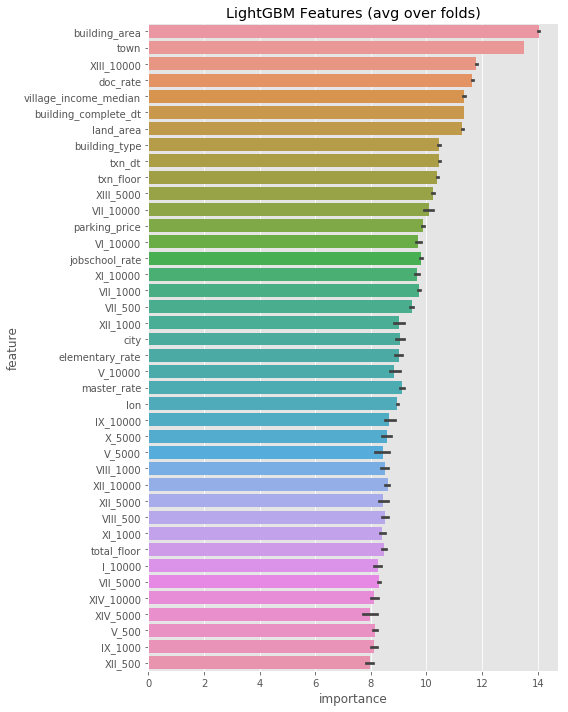

In [24]:
#7
begin = time.time()
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 

prediction = lgb_model(5, train, test, features, stratified = False)
prediction = np.expm1(prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))

In [54]:
Submission(test['building_id'], prediction)

In [55]:
gc.collect()

8984

# Record

In [ ]:
1# cv :   0.20573  hit_rate :  5054   public : 5113   note : without Fe set n_estimators = 10,000
1.1# cv : 0.20580  hit_rate :  5045   public :        note : without Fe set n_estimators = 10,000 drop village
1.2# cv : 0.20352  hit_rate :  5075   public :        note : without Fe set n_estimators = 10,000 drop village one-hot
1.3# cv : 0.20570  hit_rate :  5056   public :        note : without Fe set n_estimators = 10,000 drop with category_features

# FE and use category_features   CV : 0.20355     hit_rate : 5056  with n_estimators = 10000
# FE and use one_hot             CV : 0.20402     hit_rate : 5079  with n_estimators = 10000

# FE and use one_hot             CV : 0.20336     hit_rate : 5088  with n_estimators = 10000 fillna mean 
# FE and use category_features   CV : 0.20320     hit_rate : 5104  with n_estimators = 10000 fillna mean

# FE and use one_hot             CV : 0.20342     hit_rate : 5089  with n_estimators = 10000 fillna median 
# FE and use category_features   CV : 0.2032     hit_rate : 5097  with n_estimators = 10000 fillna median 

2#    cv : 0.19764  hit_rate :         public : 5737          note : without FE set n_estimators = 1,000,000
2.1#  cv : 0.19576  hit_rate : 5634    public : 5803.8749     note : FE set n_estimators = 1,000,000 with one-hot
2.2#  cv : 0.19582  hit_rate : 5622    public : 5803.8754     note : FE set n_estimators = 1,000,000 with category_features

2.1#  cv : 0.19576  hit_rate : 5634    public :               note : FE set n_estimators = 1,000,000 with one-hot            note :  fillna
2.2#  cv : 0.19647  hit_rate : 5636    public :           note : FE set n_estimators = 1,000,000 with category_features      note :  fillna parking_price

3# cv : 0.20471  hit_rate :  5063   public :          note :  FE set n_estimators = 10,000  without one-hot
4# cv : 0.20536  hit_rate :  5028   public :          note :  FE set n_estimators = 10,000  with one-hot    drop village
5# cv : 0.20445  hit_rate :  5081   public :          note :  FE set n_estimators = 10,000  with one-hot   
6# cv : 0.20352  hit_rate :  5075   public : 3237     note :  FE set n_estimators = 10,000  with one-hot   combine city、village and groupby encoding


